##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:

    Creates a kernel distribution for analyzing the Actinophage database
    Applies the G2T model to the Actinophage database

##### Requires: 
    data\Actinophages2022.xlsx
    phage_functions.ipynb
    
    
##### Database file: 
    actino_model_application.db
    
##### Creates:
    Fig4_MCP_Kernel_Density_all.svg
    Fig4a_MCP_Kernel_Density.svg / .png
    Fig4b_Predicted_T-numbers_for_MCP.svg / .png
    Fig4c_Percent_architectures_predicted_by_T-number.svg / .png
    Fig4_tWhole.csv
    FigS2_MCP_Genome_length_histogram.svg / .png


In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv

# import for the peak identification functions
from scipy.signal import find_peaks

# import the phage functions
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestFloor
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList
from ipynb.fs.full.phage_functions import tDictAll

In [2]:
# set the fontsize
font1 = 24
font2 = 20
font3 = 16

In [3]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

# create T dictionaries
tdict2,tdict2rev = tDictAll(7)

# set the error margin
errMar = 0.09

In [4]:
# t-numbers that are seen in both lists are 4*t, where t equals possible T_t numbers
for i in tps_h:
    if i in tps_t:
        print(i)

4.0
12.0
16.0
28.0
36.0
48.0
52.0


In [5]:
tMod = tModel()
#print(tps)
TDNA = np.exp((np.log(tps)-tMod[2])/tMod[0])
#print(TDNA)

In [6]:
# kernel density import
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# function to build kernel density data
# https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

kde_funcname = 'Scikit-learn'

In [7]:
# import updated MCP database
phageData = pd.read_excel("data/Actinophages2022.xlsx")
phageData = phageData.dropna(subset=['Genome_Length(bp)'])

In [8]:
# a little function to check whether a value can be successfully converted to an integer
def check_bp(value):
    try:
        int(value)
        return value
    except ValueError:
        return 0

In [9]:
# identify any records that do not have valid genome length values
for i in range(len(phageData)):
    if (check_bp(phageData['Genome_Length(bp)'].iloc[i])==0):
        phageData['Genome_Length(bp)'].iloc[i]=0

# and remove them
phageData = phageData[phageData['Genome_Length(bp)']!=0]

# now change those values to integers
phageData['Genome_Length(bp)'] = phageData['Genome_Length(bp)'].astype(int)

C:\Users\nueve\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# grab the complete genome size
#xMCP1 = np.asarray(phageData["Genome_Length(bp)"]).reshape(-1, 1)
xMCP1 = np.asarray(phageData["Genome_Length(bp)"]/1000)
xlinMCP = np.linspace(0,max(xMCP1)+10, int(max(xMCP1)+10))
n = len(xMCP1)

In [11]:
# check for best bandwidth
grid = GridSearchCV(KernelDensity(),
                {'bandwidth': np.linspace(1, 20, 50)})
grid.fit(xMCP1[:, None])
print(grid.best_params_)

# create kernel density estimates
pdfMCP = kde_sklearn(xMCP1, xlinMCP, bandwidth=grid.best_params_['bandwidth'])

{'bandwidth': 1.0}


In [12]:
# find the maximum value from all the estimates and use it to set an upper y limit
maxYlim = round(max(pdfMCP),2)

Text(0, 0.5, 'Density Distribution')

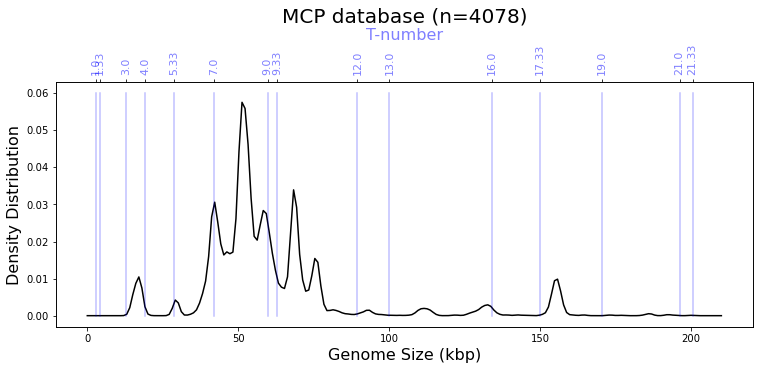

In [13]:
# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
#plt.legend(loc="upper right")

y_range = np.linspace(0,maxYlim,2)

tnums = tps[:15]
x_tnums = TDNA[:15]

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

ax.set_title('MCP database (n=' + str(n) + ")", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
#plt.savefig("results/Fig4_MCP_Kernel_Density_all1.png")
#plt.savefig("Fig4_MCP_Kernel_Density_all.svg");

(array([ 61.,  92.,   2.,   0.,   0.,   4.,  42.,   1.,   7.,  46., 132.,
        357., 140., 162., 503., 510., 193., 271., 237., 106.,  70., 281.,
        198.,  63., 153.,  70.,  13.,  14.,   5.,   3.,   7.,  14.,   8.,
          3.,   1.,   1.,   0.,   2.,  17.,  18.,   9.,   0.,   0.,   2.,
          1.,   8.,  14.,  33.,  16.,   3.,   2.,   2.,   1.,   0.,   0.,
          6.,  80.,  73.,   3.,   1.,   2.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   1.,   6.,   0.,   2.,   2.,   0.,   1.]),
 array([ 14.27   ,  16.74704,  19.22408,  21.70112,  24.17816,  26.6552 ,
         29.13224,  31.60928,  34.08632,  36.56336,  39.0404 ,  41.51744,
         43.99448,  46.47152,  48.94856,  51.4256 ,  53.90264,  56.37968,
         58.85672,  61.33376,  63.8108 ,  66.28784,  68.76488,  71.24192,
         73.71896,  76.196  ,  78.67304,  81.15008,  83.62712,  86.10416,
         88.5812 ,  91.05824,  93.53528,  96.01232,  98.48936, 100.9664 ,
        103.44344, 105.92048, 108.39752, 110.874

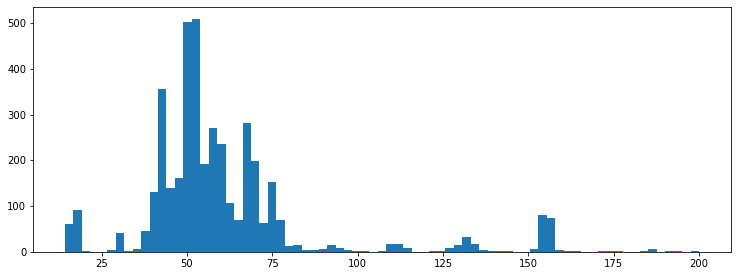

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.hist(xMCP1, bins=75)

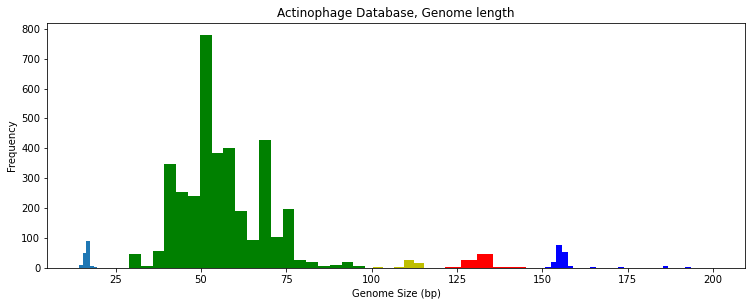

In [15]:
# break the MCPs up into groups
b1 = 25
b2 = 100
b3 = 120
b4 = 150

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
xMCP1a = xMCP1[xMCP1<b1]
xMCP1b = xMCP1[xMCP1>=b1]
xMCP1b = xMCP1b[xMCP1b<b2]
xMCP1c = xMCP1[xMCP1>=b2]
xMCP1c = xMCP1c[xMCP1c<b3]
xMCP1d = xMCP1[xMCP1>=b3]
xMCP1d = xMCP1d[xMCP1d<b4]
xMCP1e = xMCP1[xMCP1>=b4]

plt.hist(xMCP1a, bins=5)
plt.hist(xMCP1b, bins=20, color='g')
plt.hist(xMCP1c, bins=5, color='y')
plt.hist(xMCP1d, bins=5, color='r')
plt.hist(xMCP1e, bins=30, color='b')

plt.xlabel("Genome Size (bp)")
plt.ylabel("Frequency")
plt.title("Actinophage Database, Genome length")
plt.show()

In [17]:
# check for best bandwidth
grid = GridSearchCV(KernelDensity(),
                {'bandwidth': np.linspace(0.01, 3, 50)},
                cv=5) 
grid.fit(xMCP1a[:, None])
print('xMCP1a, < %d kbps' % b1)
pct_a = len(xMCP1a)/len(xMCP1)
print('%d structures representing %.2f percent of the total number of structures' % (len(xMCP1a), pct_a))
bw_a = round(grid.best_params_["bandwidth"],2)
print('bandwidth: %.2f' % bw_a)
grid.fit(xMCP1b[:, None])
print('xMCP1b, %d-%d kbps' % (b1,b2))
pct_b = len(xMCP1b)/len(xMCP1)
print('%d structures representing %.2f percent of the total number of structures' % (len(xMCP1b), pct_b))
bw_b = round(grid.best_params_["bandwidth"],2)
print('bandwidth: %.2f' % bw_b)
grid.fit(xMCP1c[:, None])
print('xMCP1c, %d-%d kbps' % (b2,b3))
pct_c = len(xMCP1c)/len(xMCP1)
print('%d structures representing %.2f percent of the total number of structures' % (len(xMCP1c), pct_c))
bw_c = round(grid.best_params_["bandwidth"],2)
print('bandwidth: %.2f' % bw_c)
grid.fit(xMCP1d[:, None])
print('xMCP1d, > %d kbps' % b3)
pct_d = len(xMCP1d)/len(xMCP1)
print('%d structures representing %.2f percent of the total number of structures' % (len(xMCP1d), pct_d))
bw_d = round(grid.best_params_["bandwidth"],2)
print('bandwidth: %.2f' % bw_d)
grid.fit(xMCP1e[:, None])
print('xMCP1e, > %d kbps' % b4)
pct_d = len(xMCP1e)/len(xMCP1)
print('%d structures representing %.2f percent of the total number of structures' % (len(xMCP1e), pct_d))
bw_e = round(grid.best_params_["bandwidth"],2)
print('bandwidth: %.2f' % bw_e)


xMCP1a, < 25 kbps
155 structures representing 0.04 percent of the total number of structures
bandwidth: 0.07
xMCP1b, 25-100 kbps
3613 structures representing 0.89 percent of the total number of structures
bandwidth: 0.25
xMCP1c, 100-120 kbps
48 structures representing 0.01 percent of the total number of structures
bandwidth: 1.60
xMCP1d, > 120 kbps
82 structures representing 0.02 percent of the total number of structures
bandwidth: 1.60
xMCP1e, > 150 kbps
180 structures representing 0.04 percent of the total number of structures
bandwidth: 1.23


In [18]:
# break the MCPs up into groups
b1 = 25
b2 = 100
b3 = 150

In [27]:
# make the linspace, ensuring that our total x-space is continuous
xlinMCPa = np.linspace(int(min(xMCP1a)-3), int(max(xMCP1a)+(min(xMCP1b)-max(xMCP1a))/2))
xlinMCPb = np.linspace(int(max(xMCP1a)+(min(xMCP1b)-max(xMCP1a))/2), int(max(xMCP1b)+(min(xMCP1c)-max(xMCP1b))/2))
xlinMCPc = np.linspace(int(max(xMCP1b)+(min(xMCP1c)-max(xMCP1b))/2), int(max(xMCP1c)+(min(xMCP1d)-max(xMCP1c))/2))
xlinMCPd = np.linspace(int(max(xMCP1c)+(min(xMCP1d)-max(xMCP1c))/2), int(max(xMCP1d)))

# create kernel density estimates
pdfMCPa = kde_sklearn(xMCP1a, xlinMCPa, bandwidth=bw_a)
pdfMCPb = kde_sklearn(xMCP1b, xlinMCPb, bandwidth=bw_b)
pdfMCPc = kde_sklearn(xMCP1c, xlinMCPc, bandwidth=bw_c)
pdfMCPd = kde_sklearn(xMCP1d, xlinMCPd, bandwidth=bw_d)

# normalize each and multiply by percent population
normPDF_a = np.asarray([float(i)/sum(pdfMCPa) for i in pdfMCPa])*pct_a
normPDF_b = np.asarray([float(i)/sum(pdfMCPb) for i in pdfMCPb])*pct_b
normPDF_c = np.asarray([float(i)/sum(pdfMCPc) for i in pdfMCPc])*pct_c
normPDF_d = np.asarray([float(i)/sum(pdfMCPd) for i in pdfMCPd])*pct_d

# smooth the y space
normPDF_a[-1] = (normPDF_a[-1]+normPDF_b[0])/2
normPDF_b[0]= normPDF_a[-1] = (normPDF_a[-1]+normPDF_b[0])/2
normPDF_b[-1] = (normPDF_b[-1]+normPDF_c[0])/2
normPDF_c[0]= (normPDF_b[-1]+normPDF_c[0])/2
normPDF_c[-1] = (normPDF_c[-1]+normPDF_d[0])/2
normPDF_d[0]= (normPDF_c[-1]+normPDF_d[0])/2

Text(0, 0.5, 'Density Distribution')

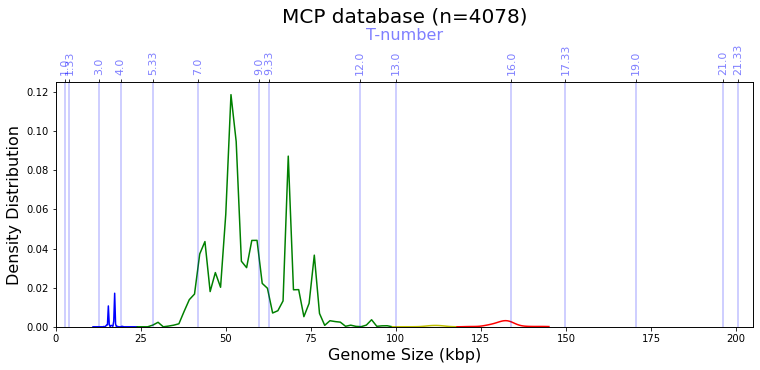

In [28]:
# MCP database kernel dist
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCPa, normPDF_a, color='b') 
plt.plot(xlinMCPb, normPDF_b, color='g') 
plt.plot(xlinMCPc, normPDF_c, color='y') 
plt.plot(xlinMCPd, normPDF_d, color='r') 
#plt.plot(xlinMCP, pdfMCP, color='black', label='MCP db') 
plt.ylim((0,.125))
plt.xlim((0,205))
#plt.legend(loc="upper right")

y_range = np.linspace(0,.125,2)

tnums = tps[:15]
x_tnums = TDNA[:15]

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

ax.set_title('MCP database (n=' + str(n) + ")", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
#plt.savefig("results/Fig4_MCP_Kernel_Density_all1.png")
#plt.savefig("Fig4_MCP_Kernel_Density_all.svg");

In [21]:
# create a truncated t list with zero at the end
n_t = 15
tps3 = tps[:n_t]
tps3 = np.insert(tps3,n_t,0)
tps3
tps3_DNA = []

for i in range(n_t):
    tps3_DNA.append(tps3[i])
    tps3_DNA.append(TDNA[i])
    tps3_DNA.append(TDNA[i]-TDNA[i]*errMar)
    tps3_DNA.append(TDNA[i]+TDNA[i]*errMar)

tps3_DNA = np.reshape(np.ravel(tps3_DNA), (-1, 4));
tps3_DNA = np.asarray(tps3_DNA)

print("  T-num  ---  exact DNA  ---  low DNA  ---  high DNA")
print(tps3_DNA)

y_pos = np.arange(len(tps3))

  T-num  ---  exact DNA  ---  low DNA  ---  high DNA
[[  1.           2.73784255   2.49143672   2.98424838]
 [  1.33         4.085017     3.71736547   4.45266853]
 [  3.          12.7906495   11.63949104  13.94180795]
 [  4.          19.15152591  17.42788858  20.87516324]
 [  5.33        28.65056418  26.0720134   31.22911496]
 [  7.          41.99794576  38.21813065  45.77776088]
 [  9.          59.75534083  54.37736016  65.13332151]
 [  9.33        62.85229702  57.19559029  68.50900376]
 [ 12.          89.47207555  81.41958875  97.52456235]
 [ 13.         100.10708032  91.09744309 109.11671755]
 [ 16.         133.96714322 121.91010033 146.02418611]
 [ 17.33       149.85056252 136.36401189 163.33711314]
 [ 19.         170.49916152 155.15423698 185.84408606]
 [ 21.         196.20595214 178.54741645 213.86448783]
 [ 21.33       200.54593153 182.49679769 218.59506536]]


In [22]:
# create an empty vector to hold the ranges
x_breaks = []

# add T=1
x_breaks.append(1)
x_breaks.append(tps3_DNA[0][2])
x_breaks.append(tps3_DNA[0][3])

for i in range(1,len(tps3_DNA)-1):
    if (tps3_DNA[i][2]>tps3_DNA[i-1][3]):
        x_breaks.append(1)
        x_breaks.append(tps3_DNA[i][2])
    if (tps3_DNA[i][3]<=tps3_DNA[i+1][2]):
        x_breaks.append(tps3_DNA[i][3])
        
if (len(x_breaks)%3 ==2):
        x_breaks.append(tps3_DNA[-1][3])

T_ranges = np.asarray(x_breaks)
T_ranges = np.asarray(np.reshape(np.ravel(T_ranges), (-1, 3)))

df_T_ranges = pd.DataFrame(T_ranges)
df_T_ranges = df_T_ranges.rename(columns={0: 'Color', 1: 'lower', 2: 'upper'})
df_T_ranges

,Color,lower,upper
0,1.0,2.491437,2.984248
1,1.0,3.717365,4.452669
2,1.0,11.639491,13.941808
3,1.0,17.427889,20.875163
4,1.0,26.072013,31.229115
5,1.0,38.218131,45.777761
6,1.0,54.377360,68.509004
7,1.0,81.419589,109.116718
8,1.0,121.910100,218.595065


In [23]:
# create a new x linspace that includes the exact T-endpoints
xlinMCP3 = np.sort(np.concatenate((xlinMCP,T_ranges[:,1],T_ranges[:,2]),axis=0))

# create the kernel density to match
pdfMCP3 = kde_sklearn(xMCP1, xlinMCP3, bandwidth=1)

# find peaks
peaks, _ = find_peaks(pdfMCP3, height=0)

Text(0, 0.5, 'Density Distribution')

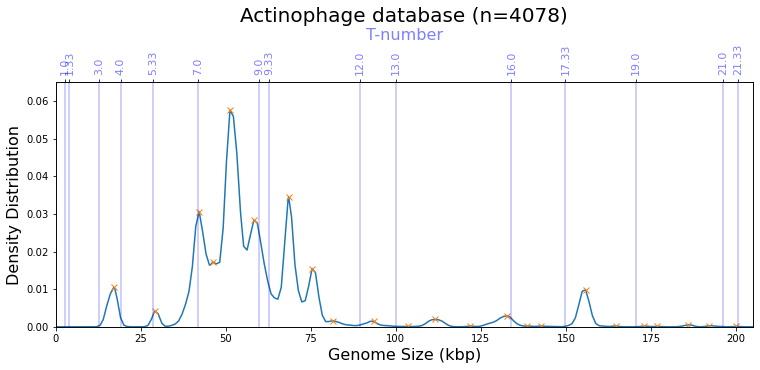

In [24]:
# Plot the actinophage database kernel dist with peaks
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCP3, pdfMCP3)
plt.plot(xlinMCP3[peaks], pdfMCP3[peaks], "x")


plt.ylim((0,.065))
plt.xlim((0,205))
#plt.legend(loc="upper right")

y_range = np.linspace(0,.065,2)

tnums = tps[:15]
x_tnums = TDNA[:15]

for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add another x
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

ax.set_title('Actinophage database (n=' + str(n) + ")", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)
#plt.savefig("results/Fig4_MCP_Kernel_Density_all1.png")
#plt.savefig("Fig4_MCP_Kernel_Density_all.svg");

Text(0, 0.5, 'Density Distribution')

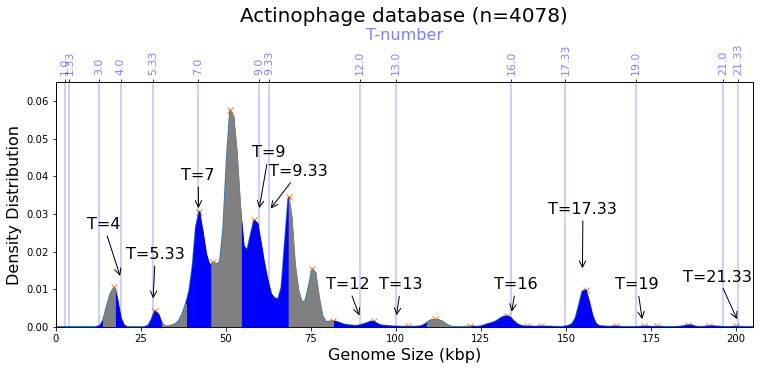

In [25]:
# Plot the actinophage database kernel dist with peaks
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlinMCP3, pdfMCP3)
plt.plot(xlinMCP3[peaks], pdfMCP3[peaks], "x")

plt.ylim((0,.065))
plt.xlim((0,205))

y_range = np.linspace(0,.065,2)

tnums = tps[:15]
x_tnums = TDNA[:15]

# add lines for the exact T-numbers
for i in range(len(tnums)):
    x_range = [x_tnums[i],x_tnums[i]]
    plt.plot(x_range,y_range, color="blue",alpha=0.25)
    
# add info for second x 
new_tick_locations = np.array(x_tnums)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tnums, fontsize=11, color="blue",alpha=0.5, rotation=90)
ax2.set_xlabel("T-number", fontsize=font3, color="blue",alpha=0.5)

# shade the T v. elongated regions
for j in range(len(T_ranges)):
    for i in range(len(xlinMCP3)-1):
        if xlinMCP3[i]>=T_ranges[j][1]:
            if xlinMCP3[i]<=T_ranges[j][2]:
                if xlinMCP3[i+1]>=T_ranges[j][1]:
                    if xlinMCP3[i+1]<=T_ranges[j][2]:
                        plt.fill_between([xlinMCP3[i], xlinMCP3[i+1]], [pdfMCP3[i], pdfMCP3[i+1]],-0.0005,color='blue')#
for j in range(len(T_ranges)-1):
    for i in range(len(xlinMCP3)-1):
        if xlinMCP3[i]>=T_ranges[j][2]:
            if xlinMCP3[i]<=T_ranges[j+1][1]:
                if xlinMCP3[i+1]>=T_ranges[j][2]:
                    if xlinMCP3[i+1]<=T_ranges[j+1][1]:
                        plt.fill_between([xlinMCP3[i], xlinMCP3[i+1]], [pdfMCP3[i], pdfMCP3[i+1]],-0.0005,color='gray')#

# add the T arrows
ax.annotate("T=4", xy=(tps3_DNA[3][1],0.013), xytext=(tps3_DNA[3][1]-10, 0.026),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=5.33", xy=(tps3_DNA[4][1],0.007), xytext=(tps3_DNA[4][1]-8, 0.018),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=7", xy=(tps3_DNA[5][1],0.031), xytext=(tps3_DNA[5][1]-5, 0.039),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=9", xy=(tps3_DNA[6][1],0.031), xytext=(tps3_DNA[6][1]-2, 0.045),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=9.33", xy=(tps3_DNA[7][1],0.031), xytext=(tps3_DNA[7][1], 0.04),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=12", xy=(tps3_DNA[8][1],0.0025), xytext=(tps3_DNA[8][1]-10, 0.01),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=13", xy=(tps3_DNA[9][1],0.0025), xytext=(tps3_DNA[9][1]-5, 0.01),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=16", xy=(tps3_DNA[10][1],0.0035), xytext=(tps3_DNA[10][1]-5, 0.01),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=17.33", xy=(tps3_DNA[11][1]+5,0.015), xytext=(tps3_DNA[11][1]-5, 0.03),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=19", xy=(tps3_DNA[12][1]+2,0.0015), xytext=(tps3_DNA[12][1]-6, 0.01),arrowprops=dict(arrowstyle="->"), fontsize=font3)
ax.annotate("T=21.33", xy=(tps3_DNA[14][1],0.0015), xytext=(tps3_DNA[14][1]-16, 0.012),arrowprops=dict(arrowstyle="->"), fontsize=font3)

ax.set_title('Actinophage database (n=' + str(n) + ")", fontsize=font2, pad=60)
ax.set_xlabel("Genome Size (kbp)", fontsize=font3)
ax.set_ylabel("Density Distribution", fontsize=font3)

In [26]:
# save kernel state
import dill
dill.dump_session('X_model_actino.db')

In [27]:
## load kernel state
## rerun imports cell (#1) first
#import dill
#dill.load_session('X_model_actino.db')